In [16]:
from mxnet.gluon.model_zoo.vision import mobilenet1_0


In [17]:
pretrained_net = mobilenet1_0(pretrained=True)

In [18]:
print(pretrained_net)

MobileNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(1 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=32)
    (5): Activation(relu)
    (6): Conv2D(32 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
    (8): Activation(relu)
    (9): Conv2D(1 -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    (10): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
    (11): Activation(relu)
    (12): Conv2D(64 -> 128, kernel_size=(1, 1), stride=(

In [19]:
net = mobilenet1_0(classes=2)

In [20]:
from mxnet import init

In [21]:
net.features = pretrained_net.features

In [22]:
net.output.initialize(init.Xavier())

In [23]:
from mxnet.image import color_normalize
from mxnet import image
train_augs = [
    image.ResizeAug(224),
    image.HorizontalFlipAug(0.5),  # flip the image horizontally
    image.BrightnessJitterAug(.3), # randomly change the brightness
    image.HueJitterAug(.1)         # randomly change hue
]
test_augs = [
    image.ResizeAug(224)
]
def transform(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, nd.array([label]).asscalar().astype('float32')

In [24]:

from mxnet.gluon.data.vision import ImageRecordDataset

train_rec = './data/train/train.rec'
validation_rec = './data/validation/validation.rec'
test_rec = './data/test/test.rec'
sample_rec = './data/sample/sample.rec'

trainIterator = ImageRecordDataset(
    filename=train_rec, 
    transform=lambda X, y: transform(X, y, train_augs)
)
validationIterator = ImageRecordDataset(
    filename=validation_rec,
    transform=lambda X, y: transform(X, y, test_augs)
)
testIterator = ImageRecordDataset(
    filename=test_rec,
    transform=lambda X, y: transform(X, y, test_augs)
)
sampleIterator = ImageRecordDataset(
    filename=sample_rec,
    transform=lambda X, y: transform(X, y, test_augs)
)

In [25]:

import matplotlib.pyplot as plt
from mxnet import nd
%matplotlib inline

def show_images(imgs, nrows, ncols, figsize=None):
    """plot a list of images"""
    if not figsize:
        figsize = (ncols, nrows)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            figs[i][j].imshow(imgs[i*ncols+j].asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

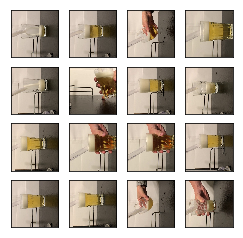


[1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
<NDArray 16 @cpu(0)>


In [26]:
from mxnet import gluon
sample_data = gluon.data.DataLoader(sampleIterator, 16, shuffle=True)
import mxnet
for i, (data, label) in enumerate(sample_data):
    img_data = data.transpose((0,2,3,1)).clip(0,255)/255
    show_images(img_data, 4, 4)
    data_normalised = color_normalize(data/255,
                           mean=mxnet.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                           std=mxnet.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
    print(label)
    break

In [27]:
import time
from mxnet.image import color_normalize
from mxnet import autograd
import mxnet as mx
from mxnet import nd

def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        data = color_normalize(data/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        output = net(data)
        prediction = nd.argmax(output, axis=1)
        acc.update(preds=prediction, labels=label)
    return acc.get()[1]

def metric_str(names, accs):
    return ', '.join(['%s=%f'%(name, acc) for name, acc in zip(names, accs)])

def train_util(net, train_iter, validation_iter, loss_fn, trainer, ctx, epochs, batch_size):
    metric = mx.metric.create(['acc'])
    for epoch in range(epochs):
        for i, (data, label) in enumerate(train_iter):
            st = time.time()
            # ensure context            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # normalize images
            data = color_normalize(data/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            
            with autograd.record():
                output = net(data)
                loss = loss_fn(output, label)

            loss.backward()
            trainer.step(data.shape[0])
            
            #  Keep a moving average of the losses
            metric.update([label], [output])
            names, accs = metric.get()
            # print('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(epoch, i, batch_size/(time.time()-st), metric_str(names, accs)))
#             if i%100 == 0:
#                 net.collect_params().save('./checkpoints/%d-%d.params'%(epoch, i))

        train_acc = evaluate_accuracy(train_iter, net)
        validation_acc = evaluate_accuracy(validation_iter, net)
        print("Epoch %s | training_acc %s | val_acc %s " % (epoch, train_acc, validation_acc))

In [28]:
def train(net, ctx, 
          batch_size=64, epochs=10, learning_rate=0.01, wd=0.001):
    train_data = gluon.data.DataLoader(
        trainIterator, batch_size, shuffle=True)
    validation_data = gluon.data.DataLoader(
        validationIterator, batch_size)

    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': wd})
    
    train_util(net, train_data, validation_data, 
               loss, trainer, ctx, epochs, batch_size)

In [ ]:
import mxnet as mx
ctx = mx.cpu()
train(net, ctx, batch_size=64, epochs=3, learning_rate=0.003)

Epoch 0 | training_acc 0.9859375 | val_acc 0.993932038835 


In [21]:
test_data_loader = gluon.data.DataLoader(testIterator, 64)

In [22]:
test_acc = evaluate_accuracy(test_data_loader, net)

In [23]:
print(test_acc)

0.997572815534


In [24]:

import matplotlib.pyplot as plt
%matplotlib inline

def predict_beer(net, fname):
    with open(fname, 'rb') as f:
        img = image.imdecode(f.read())
    data, _ = transform(img, -1, test_augs)
    plt.imshow(data.transpose((1,2,0)).asnumpy()/255)
    data = data.expand_dims(axis=0)
    data = color_normalize(data/255,
                           mean=nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                           std=nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
    out = net(data.as_in_context(mxnet.cpu()))
    plt.imshow(img.asnumpy())
    pred, label = get_label_and_prod(out)
    print('Pred: %s'% label)

def get_label_and_prod(out):
    labels = ['full', 'empty']
    pred = int(nd.argmax(out, axis=1).asscalar())
    return pred, labels[pred]

Pred: empty


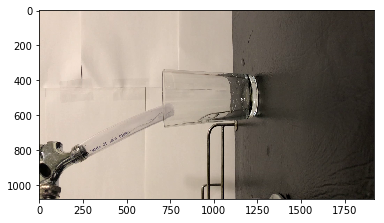

In [25]:
predict_beer(net, './data/img/empty_0_0.png')

Pred: full


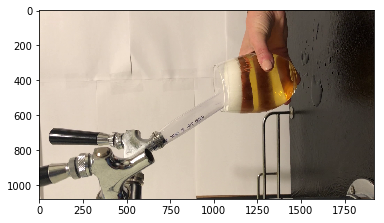

In [26]:
predict_beer(net, './data/img/full_3_1247.png')

Pred: full


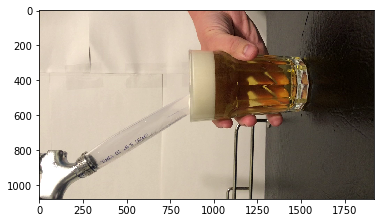

In [45]:
predict_beer(net, './data/img/full_5_750.png')

In [40]:
y = net(mx.sym.var('data'))

In [41]:
y

<Symbol mobilenet1_dense0_fwd>

In [42]:
print(y)

<Symbol mobilenet1_dense0_fwd>


In [46]:
y.save('./mobilenet_model.json')

In [47]:
net.collect_params().save('./mobilenet_model.params')

In [1]:
print(y)

NameError: name 'y' is not defined